<a href="https://www.kaggle.com/code/mikedelong/python-load-chart-and-map?scriptVersionId=140684101" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/human-trafficking-victims-dataset-ctdc/the_global_k_anon_dataset.csv', 
                 low_memory=False, sep=';')
# the first column is all null so we can drop it
df = df.iloc[:, 1:]
# we need iso-3 codes for countries so we can make choropleths
continents_df = pd.read_csv(filepath_or_buffer='/kaggle/input/country-mapping-iso-continent-region/continents2.csv' )
df = df.merge(right=continents_df[['alpha-2', 'alpha-3']].rename(columns={'alpha-2': 'citizenship', 'alpha-3': 'citizenship-alpha-3'}), on='citizenship',)
df = df.merge(right=continents_df[['alpha-2', 'alpha-3']].rename(columns={'alpha-2': 'CountryOfExploitation', 'alpha-3': 'CountryOfExploitation-alpha-3'}), on='CountryOfExploitation',)
# turns out we have a significant number of duplicate rows
print('we have {} duplicate rows out of {} total.'.format(len(df) - len(df.drop_duplicates(ignore_index=True)), len(df)))
df = df.drop_duplicates(ignore_index=True)
df.info()

we have 77084 duplicate rows out of 97750 total.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20666 entries, 0 to 20665
Data columns (total 65 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   yearOfRegistration                      20640 non-null  float64
 1   Datasource                              20666 non-null  object 
 2   gender                                  19797 non-null  object 
 3   ageBroad                                12358 non-null  object 
 4   majorityStatus                          17813 non-null  object 
 5   majorityStatusAtExploit                 8918 non-null   object 
 6   majorityEntry                           2734 non-null   object 
 7   citizenship                             8589 non-null   object 
 8   meansOfControlDebtBondage               3765 non-null   float64
 9   meansOfControlTakesEarnings             5104 non-null   float64
 10  meansOfCo

In [2]:
df.head()

,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown,citizenship-alpha-3,CountryOfExploitation-alpha-3
0,2002.0,Case Management,Female,18--20,Adult,NaN,NaN,CO,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,COL,NAM
1,2002.0,Case Management,Female,24--26,Adult,NaN,NaN,CO,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,COL,NAM
2,2002.0,Case Management,Female,30--38,Adult,NaN,NaN,CO,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,COL,NAM
3,2002.0,Case Management,Female,NaN,NaN,NaN,NaN,CO,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,COL,NAM
4,2003.0,Case Management,Female,NaN,NaN,NaN,NaN,CO,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,COL,NAM


We have so many columns and most of them are categorical, so let's use a bar chart to see how many values we have in each one (except for the country and concatenated columns)

<Axes: >

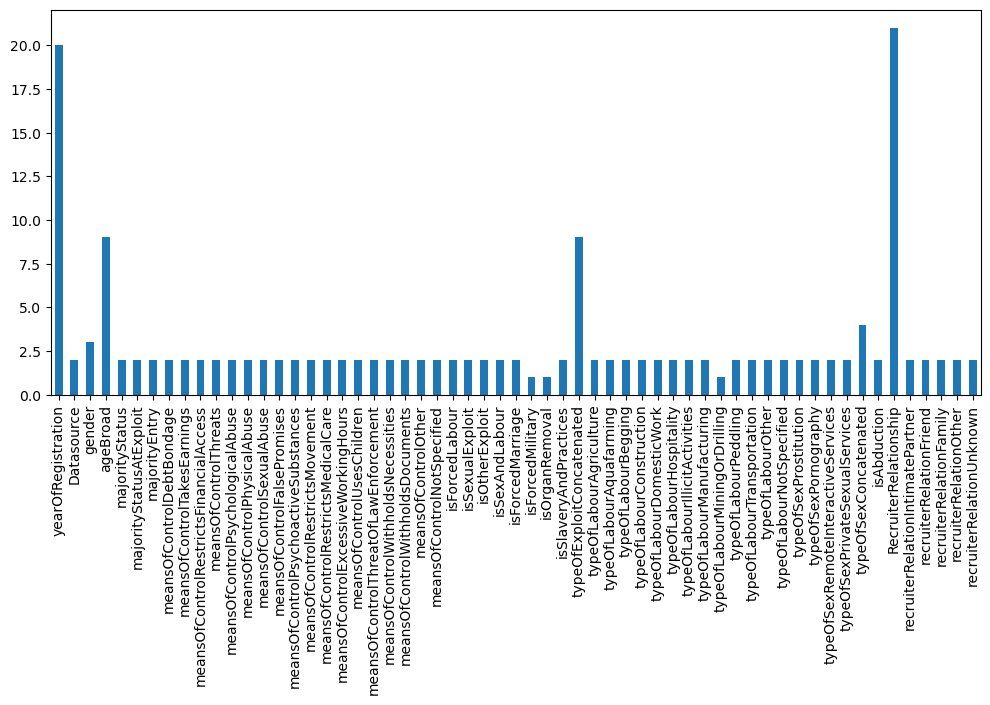

In [3]:
from matplotlib.pyplot import subplots
_, ax = subplots(figsize=(12, 5))
ignore_columns = ['meansOfControlConcatenated', 'typeOfLabourConcatenated', 
                  'citizenship', 'citizenship-alpha-3', 
                  'CountryOfExploitation', 'CountryOfExploitation-alpha-3',
                 ]
df.drop(columns=ignore_columns).nunique().plot(ax=ax, kind='bar')

<Axes: >

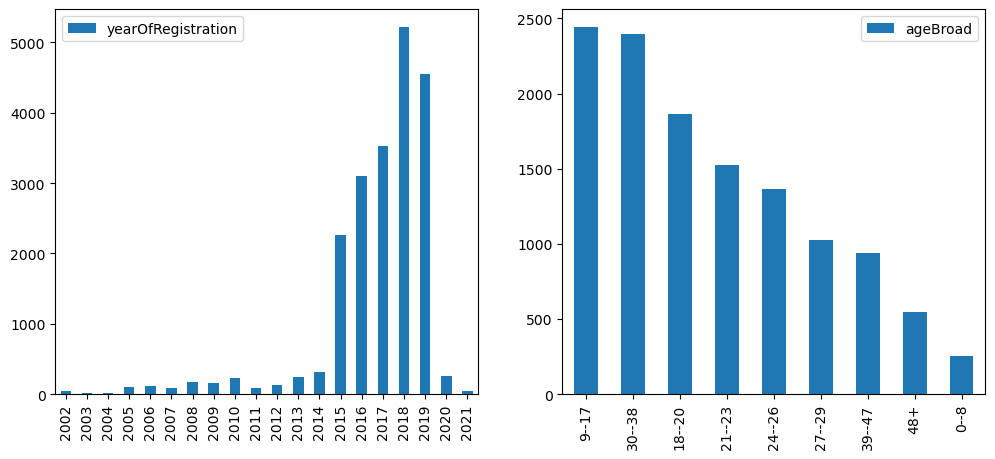

In [4]:
_, ax = subplots(figsize=(12, 5), ncols=2, )
df['yearOfRegistration'].dropna().astype(int).value_counts(sort=False).plot(ax=ax[0], kind='bar', legend=True)
df['ageBroad'].dropna().value_counts(sort=True).plot(ax=ax[1], kind='bar', legend=True)

The left-hand bar chart tells a story; the right hand one is harder to understand.

In [5]:
# where do they come from?
from plotly.express import choropleth
choropleth(data_frame=df['citizenship-alpha-3'].value_counts().to_frame().reset_index().rename(columns={'index': 'country', 'citizenship-alpha-3': 'count'}), color='count', locations='country').show()

In [6]:
# where are they exploited?
choropleth(data_frame=df['CountryOfExploitation-alpha-3'].value_counts().to_frame().reset_index().rename(columns={'index': 'country', 'CountryOfExploitation-alpha-3': 'count'}), color='count', locations='country').show()

There is so much skew in these distributions maybe volumetric plots would be better.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



<Axes: >

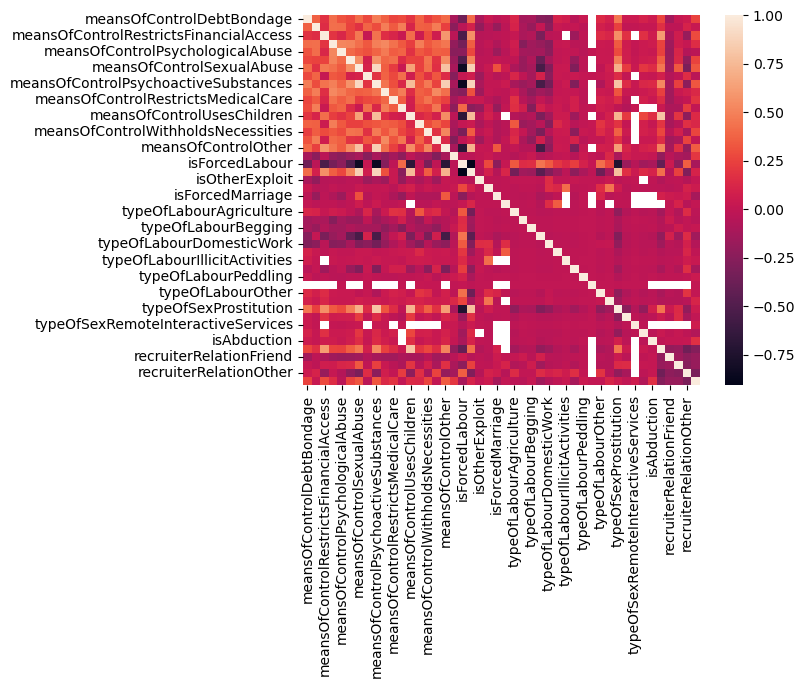

In [7]:
# we have a bunch of binary variables; how do they correlate?
from seaborn import heatmap
heatmap(data=df[[key for key, value in df.nunique().to_dict().items() if value == 2]].corr(numeric_only=True))